# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             input_pipe=None, rot_mult=4)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


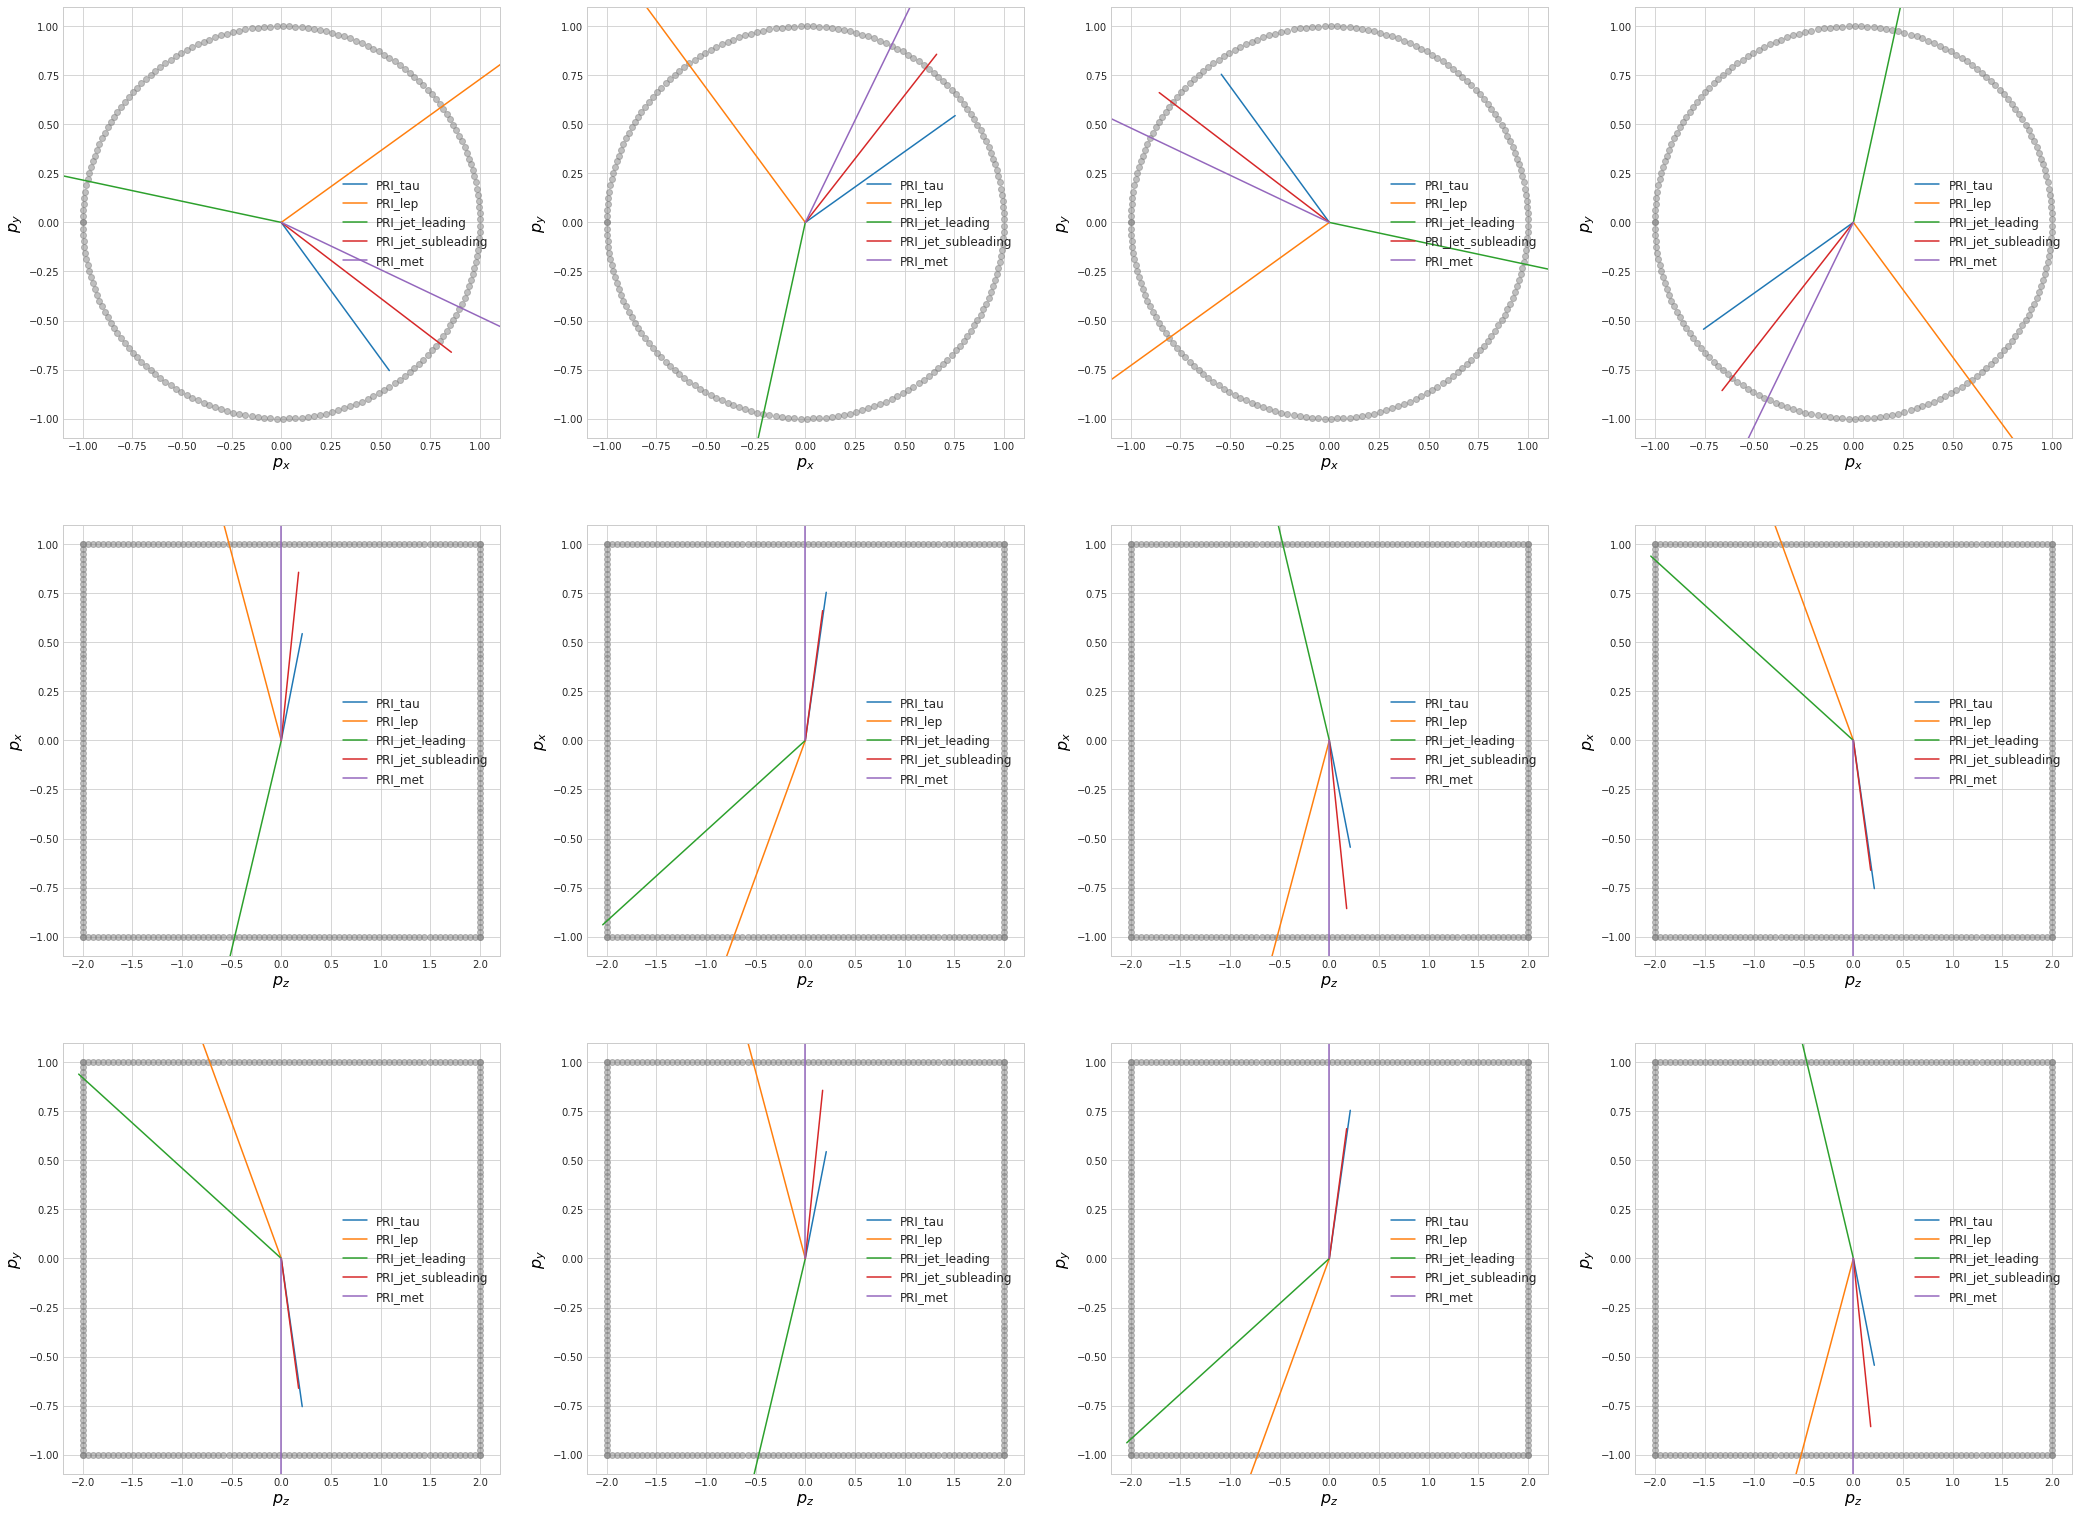

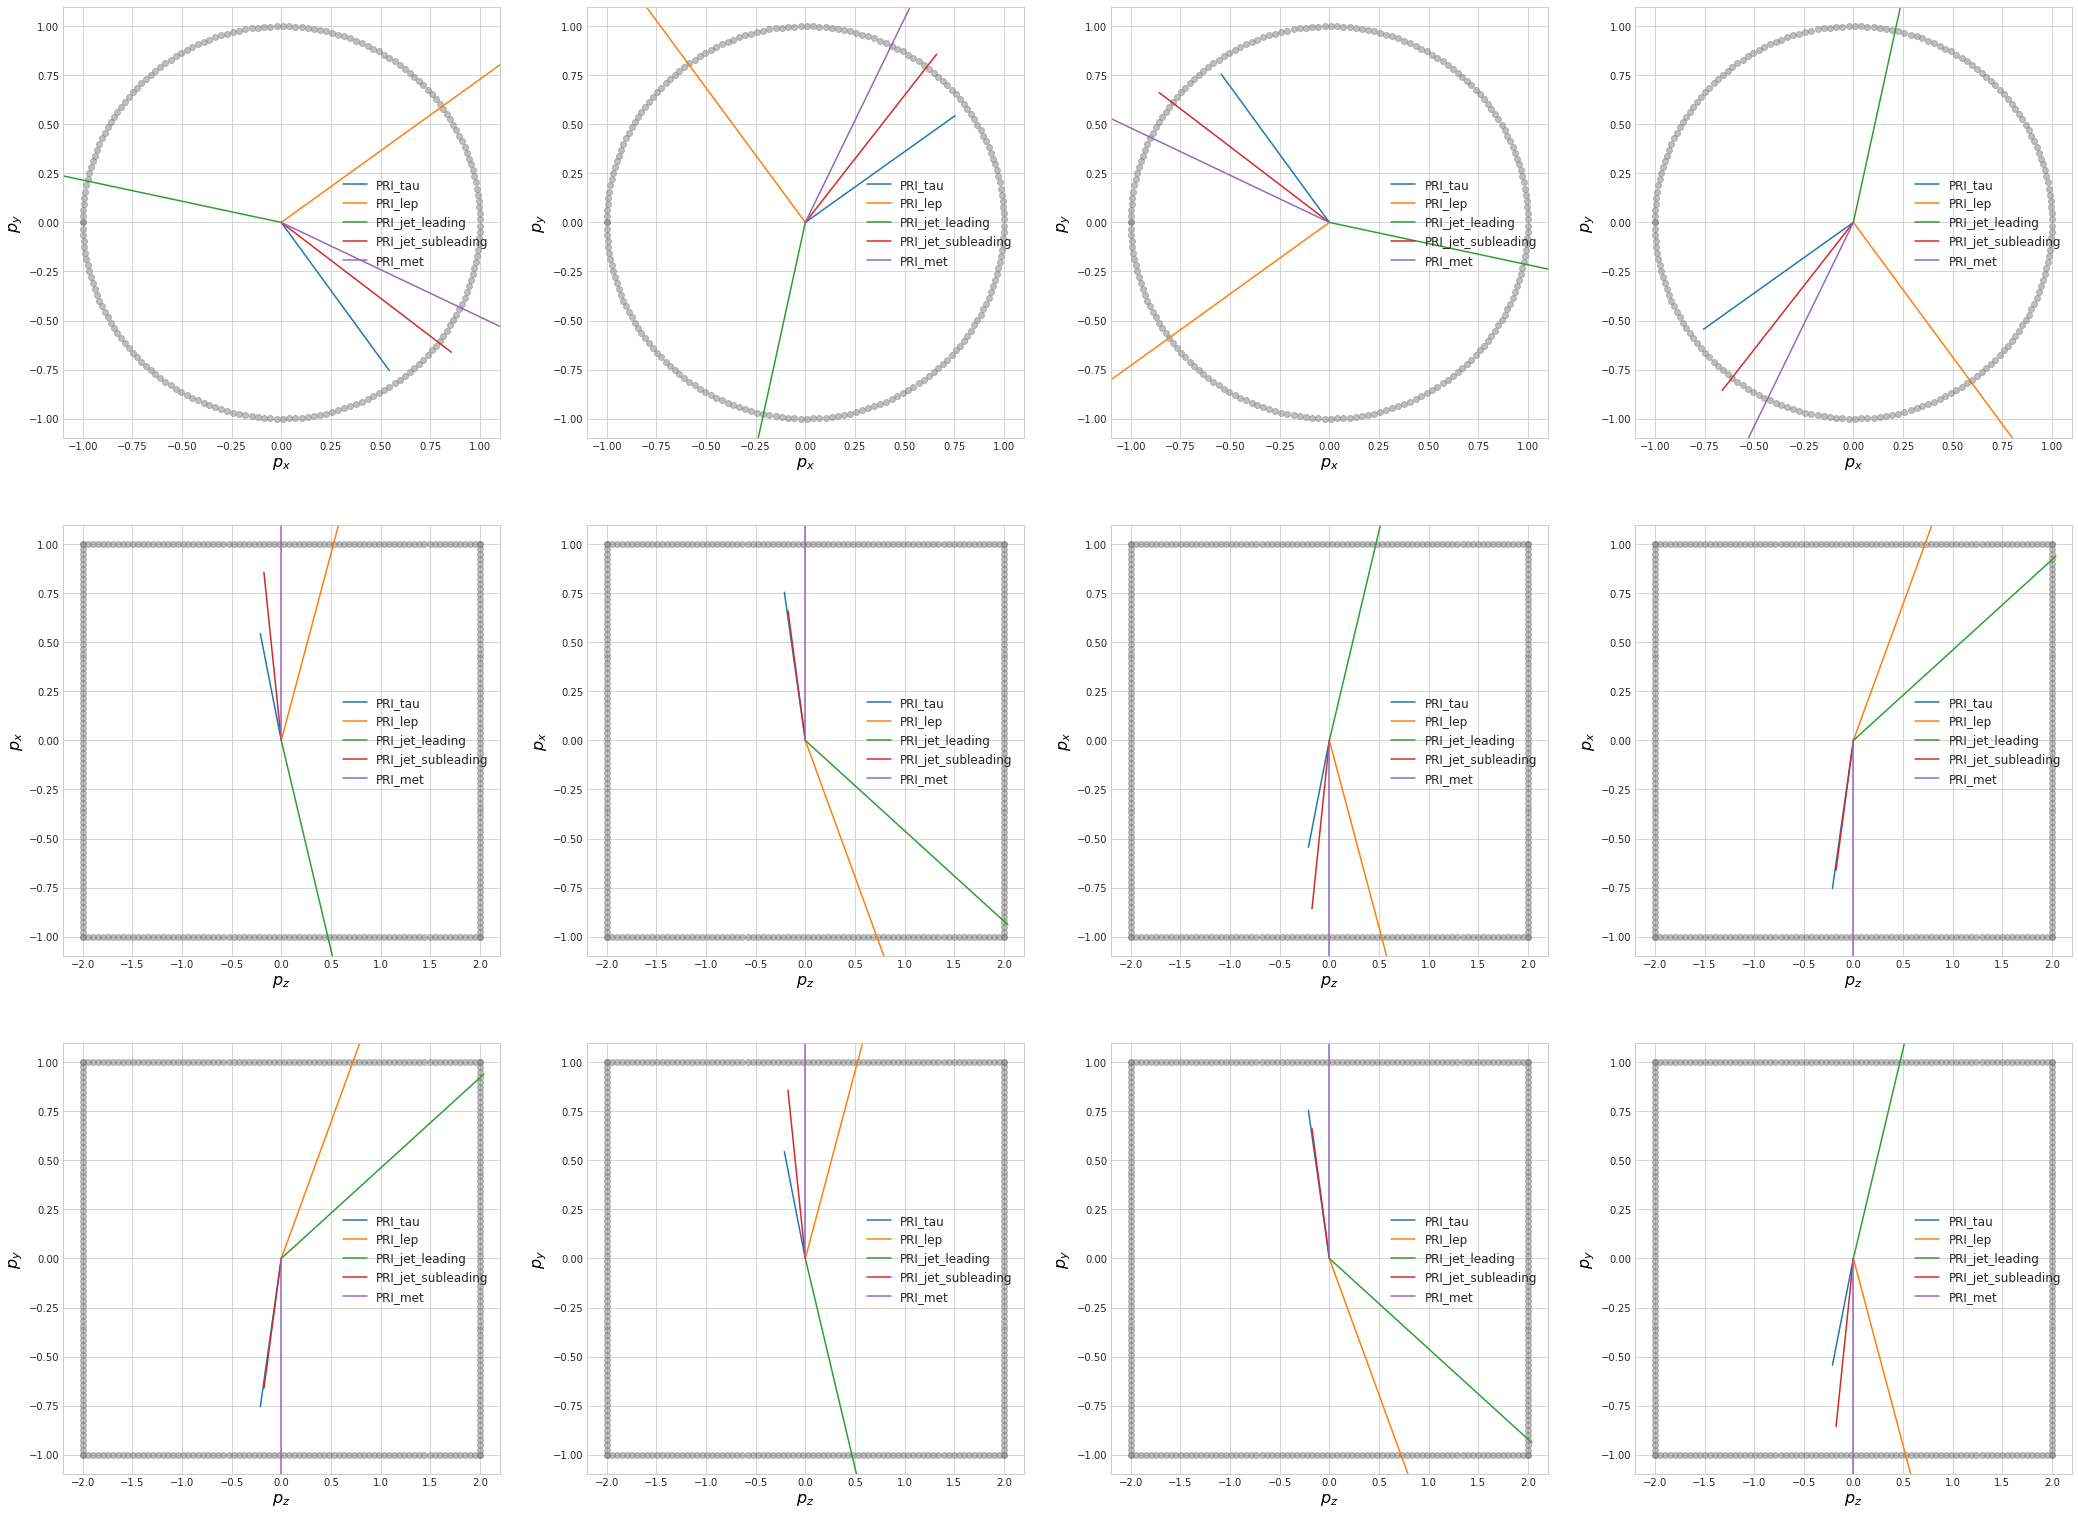

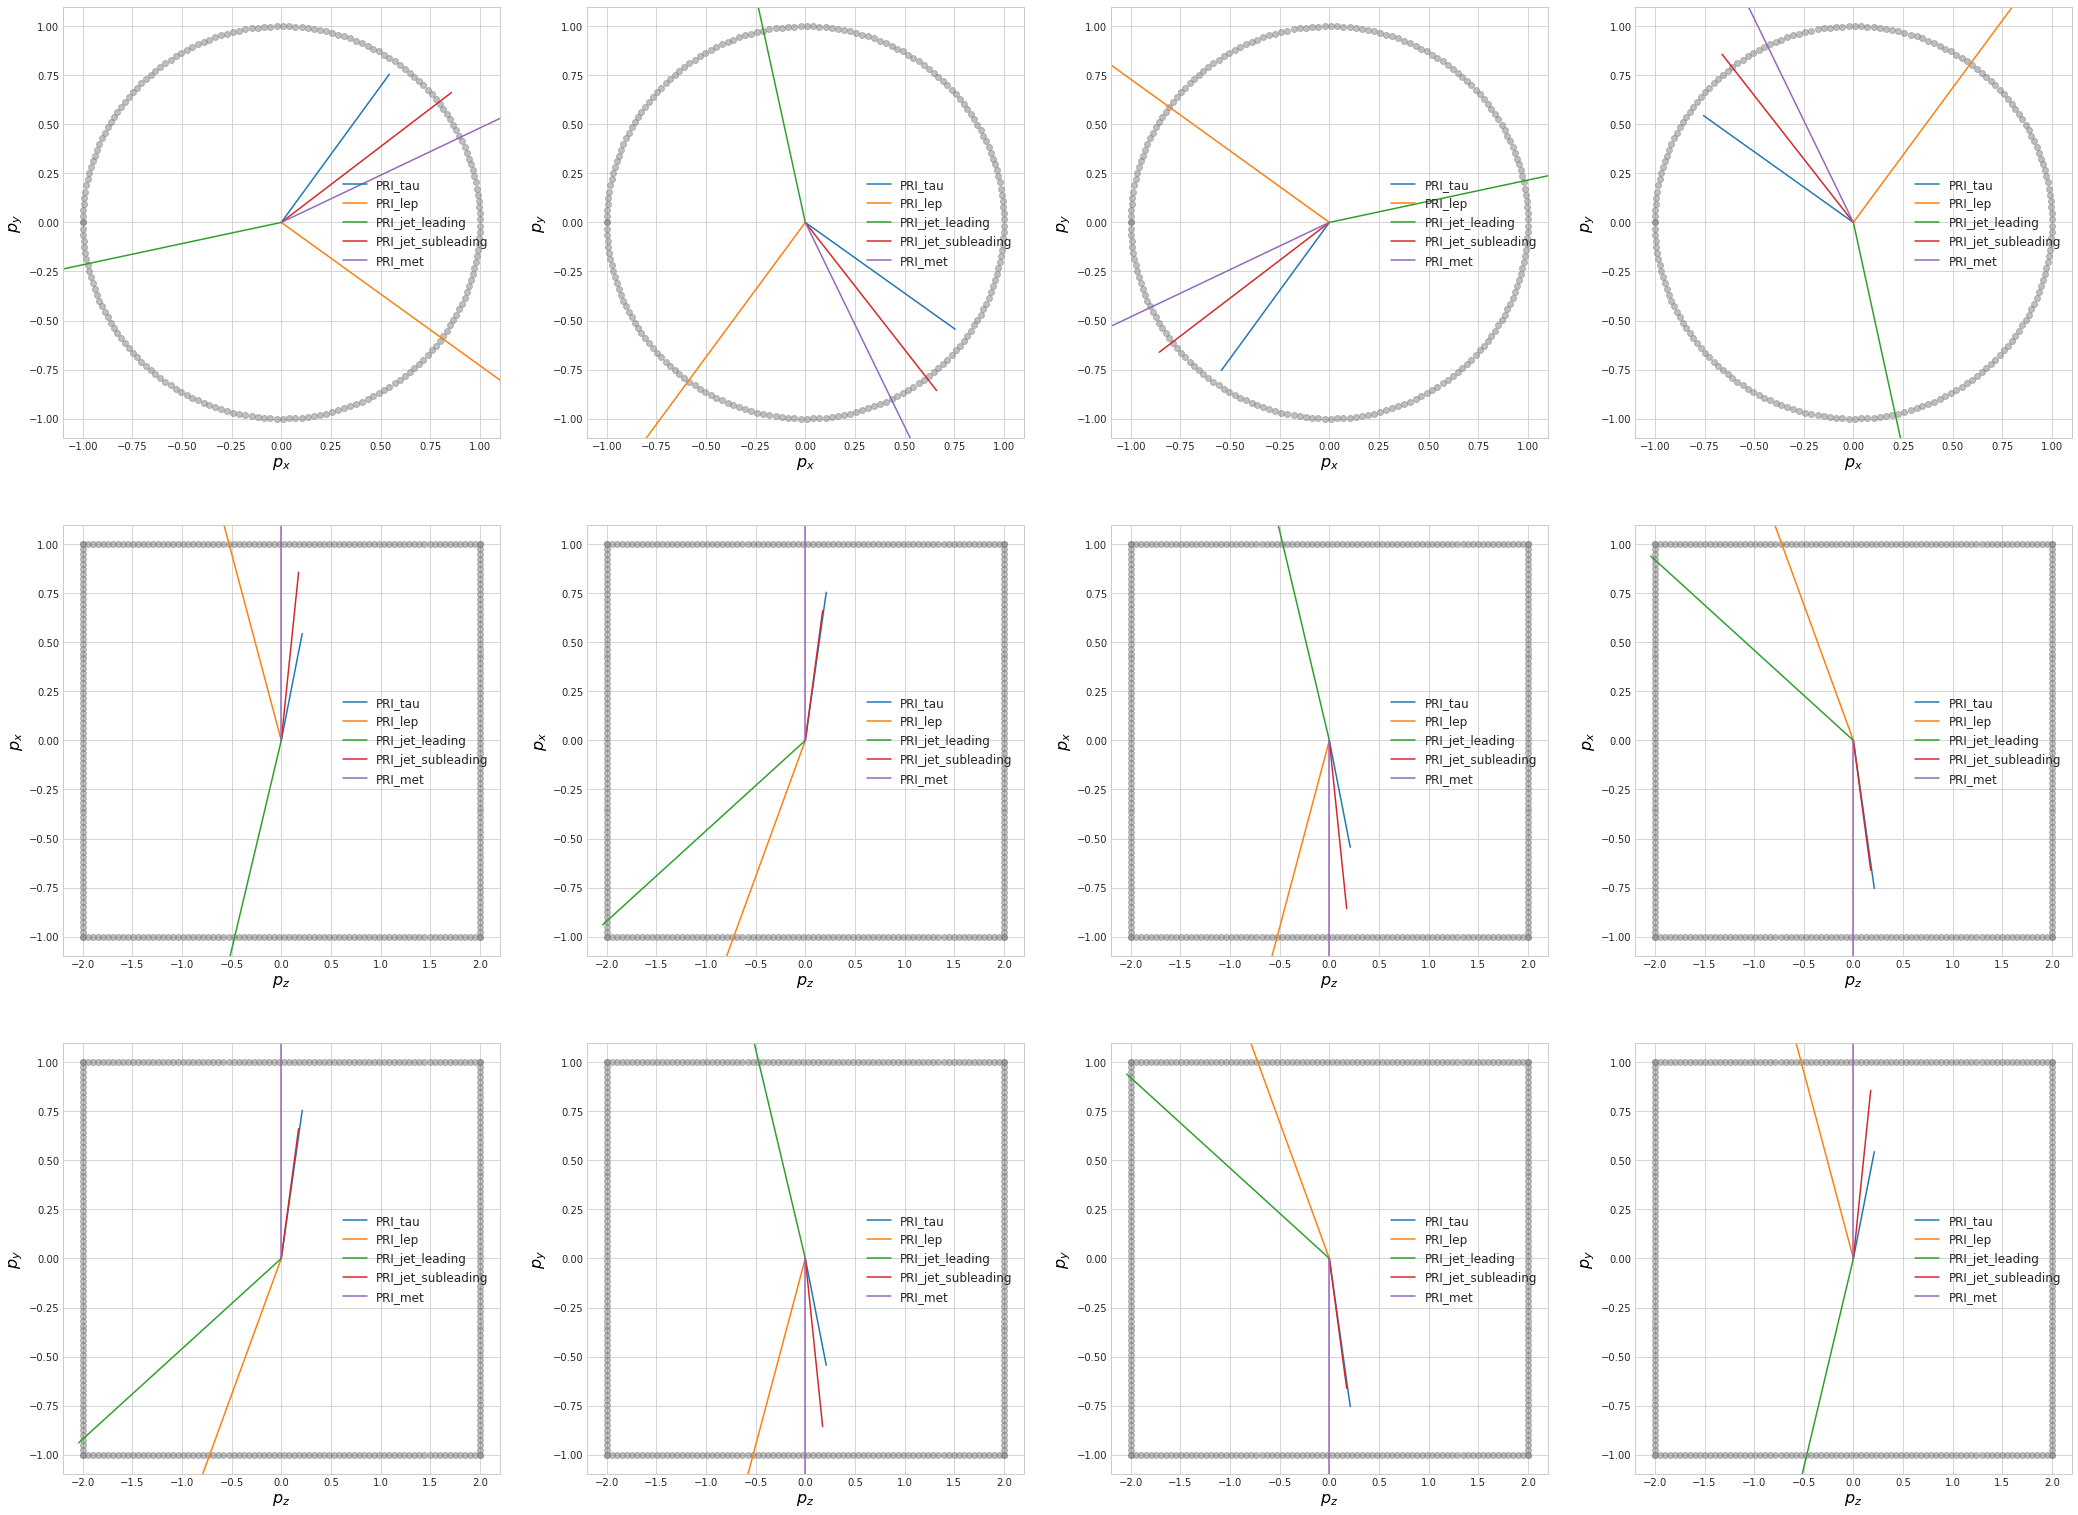

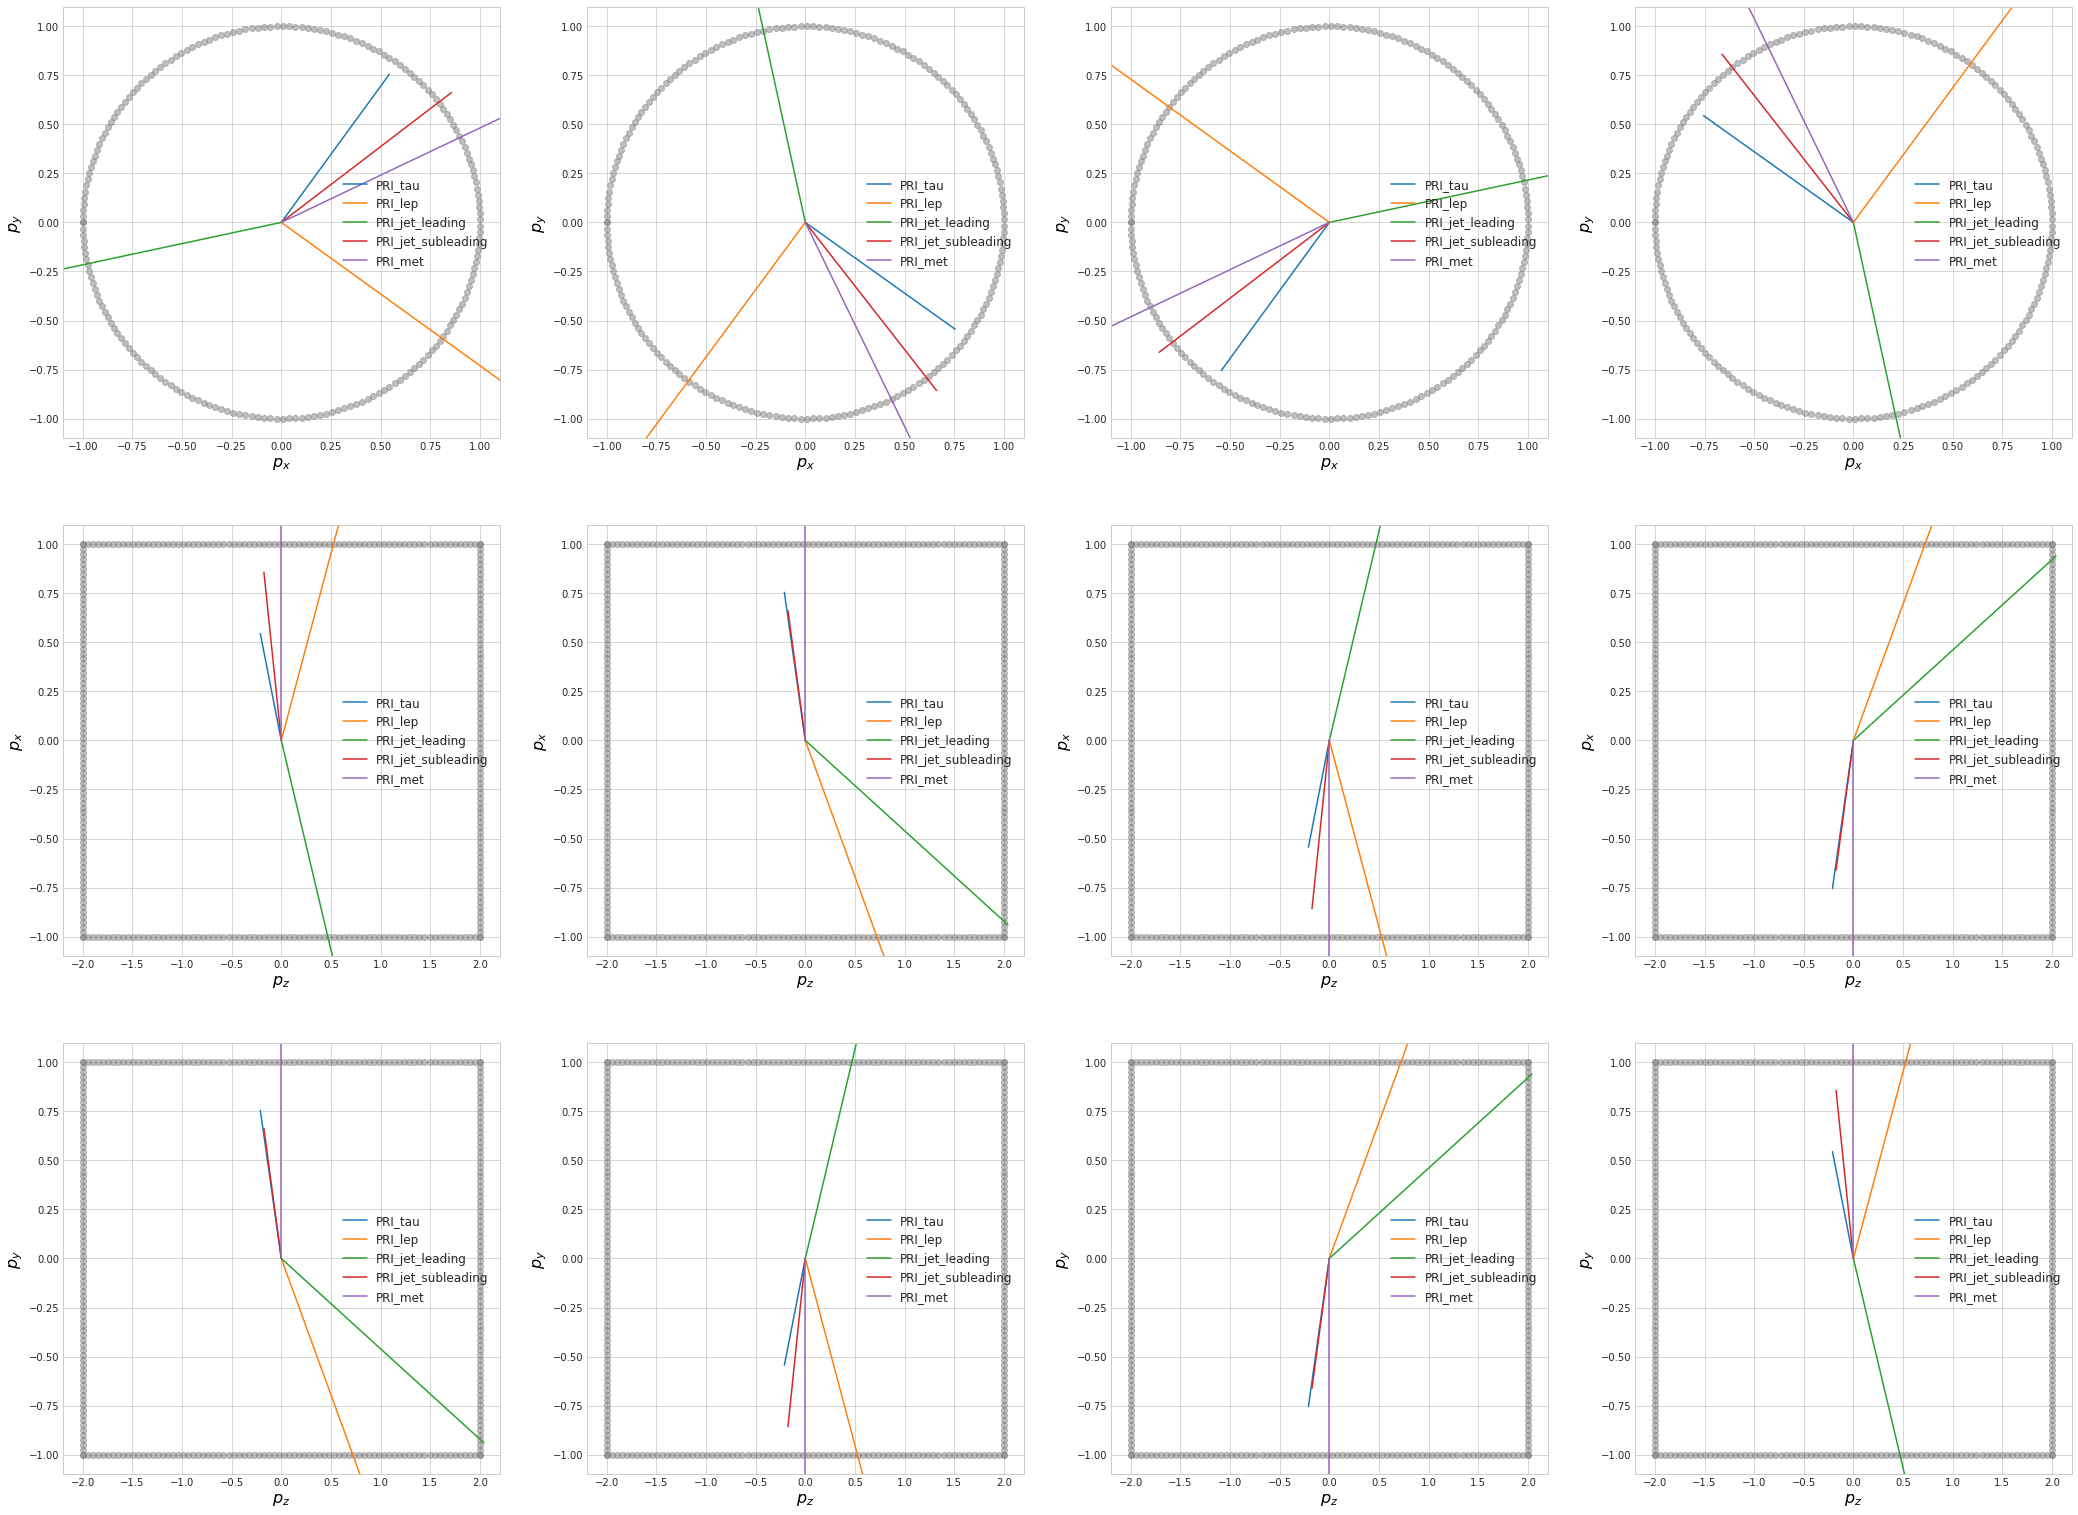

In [6]:
id=3
aug_ranges = [range(4), range(4,8), range(8,12), range(12,16)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 17.048s 


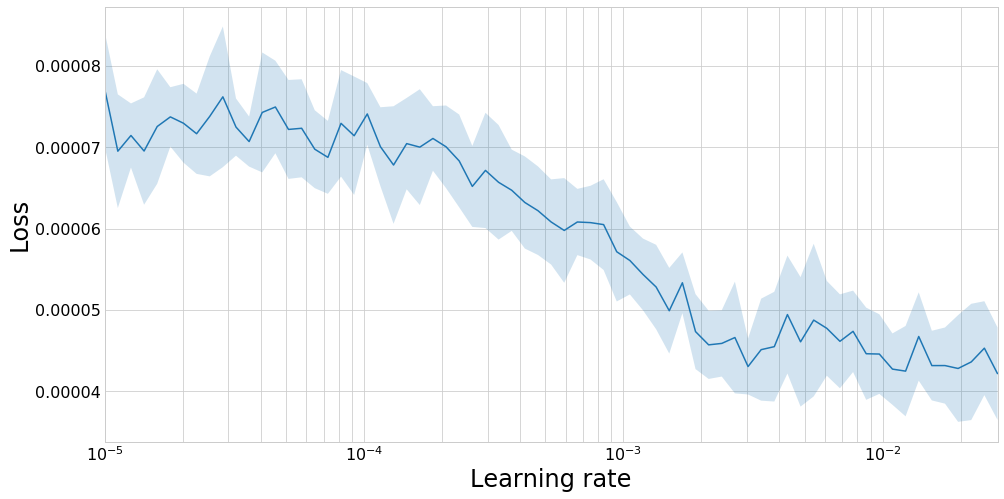

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 4.087785114153809e-05
2 New best found: 3.7512483892932006e-05
3 New best found: 3.676550665313397e-05
5 New best found: 3.582839847932825e-05
6 New best found: 3.527586447966427e-05
7 New best found: 3.5111787346661016e-05
11 New best found: 3.472938904983103e-05
13 New best found: 3.421252911182027e-05
14 New best found: 3.413706113193927e-05
15 New best found: 3.411168150585315e-05
25 New best found: 3.384207901220261e-05
27 New best found: 3.3792454037113887e-05
28 New best found: 3.364182116049299e-05
46 New best found: 3.3637655837322916e-05
49 New best found: 3.345515050366485e-05
52 New best found: 3.33033269154072e-05
55 New best found: 3.324931888058814e-05
57 New best found: 3.318951852856833e-05
58 New best found: 3.317066238723802e-05
59 New best found: 3.315336124836938e-05
94 New best found: 3.300620833134193e-05
100 New best found: 3.28999209

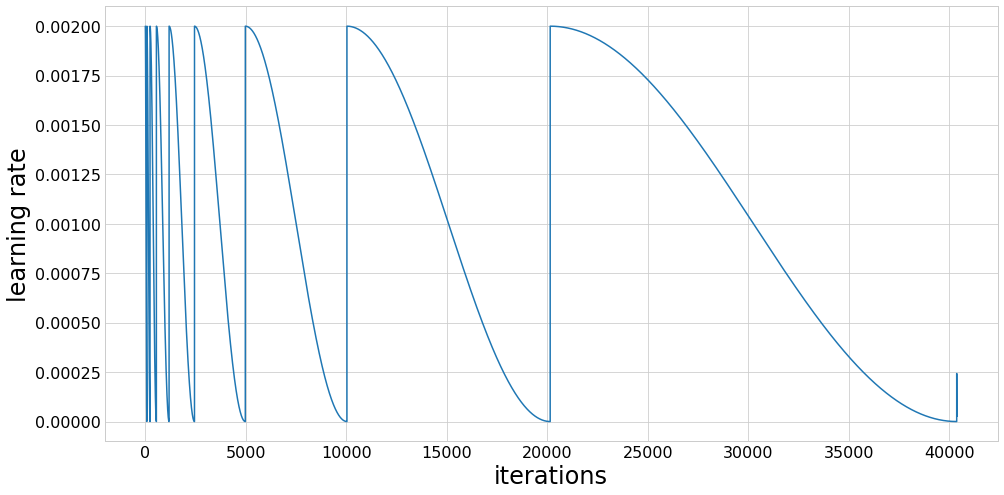

Fold took 485.013s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106543). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9212673422735656e-05
2 New best found: 3.568859891286212e-05
3 New best found: 3.48359917600644e-05
4 New best found: 3.479690305214188e-05
5 New best found: 3.4415180283990856e-05
6 New best found: 3.3627706844768394e-05
7 New best found: 3.3478200275909315e-05
9 New best found: 3.327853022838365e-05
11 New best found: 3.3227822238635914e-05
12 New best found: 3.28414026873303e-05
13 New best found: 3.258782397718338e-05
15 New best found: 3.256735893204078e-05
21 New best found: 3.256391471650765e-05
24 New best found: 3.2352371329740744e-05
26 New best found: 3.226950880747807e-05
27 New best found: 3.203027972633663e-05
29 New best found: 3.195824062894759e-05
30 New best found: 3.1942181260741897e-05
49 New best found: 3.183446282414301e-05
51 New best found: 3.182300220894561e-05
53 New best found: 3.174302051199203e-05
55 New best found: 3.173335288652256e-05
56 New best found: 3.165609484511278e-05
57 New best found: 3.15955959166287e-05
58 New best found: 3

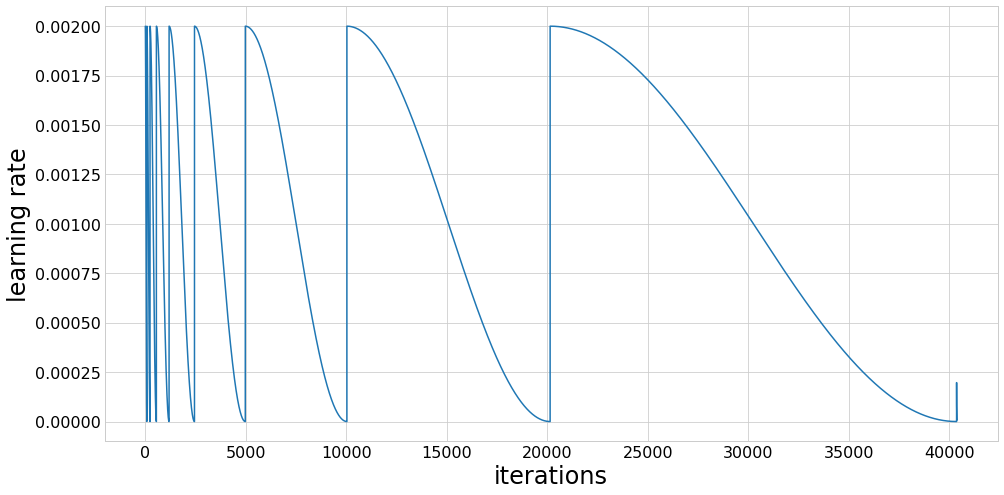

Fold took 499.955s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264789). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132726). Check your callbacks.
  % delta_t_median)


1 New best found: 3.817972649736608e-05
2 New best found: 3.5546214770805085e-05
3 New best found: 3.453771204067314e-05
4 New best found: 3.4323764331474716e-05
5 New best found: 3.3335049633691815e-05
6 New best found: 3.3234154596967464e-05
7 New best found: 3.301698127647012e-05
10 New best found: 3.265895162462867e-05
11 New best found: 3.25011061268061e-05
12 New best found: 3.214176763627863e-05
13 New best found: 3.193852662877372e-05
14 New best found: 3.184184657077614e-05
15 New best found: 3.1819134355019245e-05
23 New best found: 3.161305276258199e-05
26 New best found: 3.138862553554446e-05
29 New best found: 3.1296594963899795e-05
49 New best found: 3.122264376588057e-05
50 New best found: 3.1139643248927174e-05
53 New best found: 3.113892628105179e-05
55 New best found: 3.110436684860472e-05
56 New best found: 3.0990279971646344e-05
58 New best found: 3.0985293050980525e-05
59 New best found: 3.094097388978146e-05
95 New best found: 3.0933774166095945e-05
101 New best f

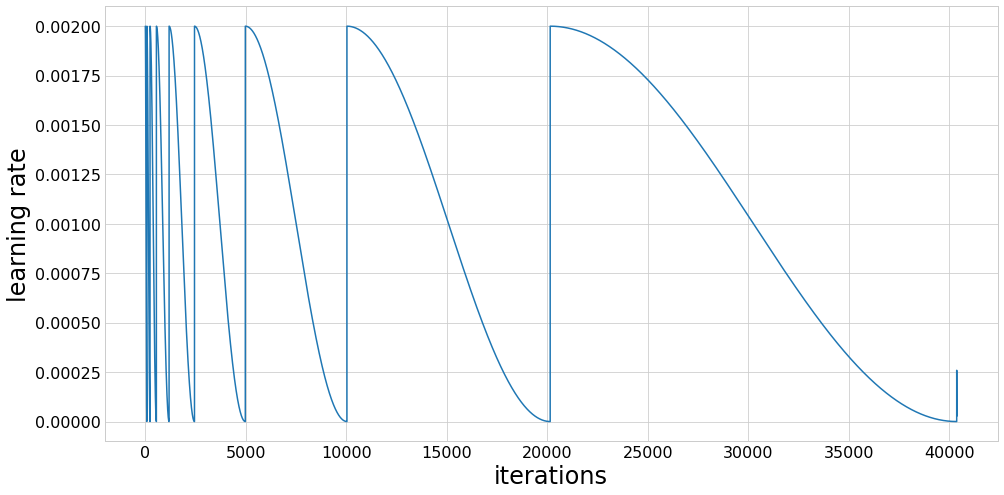

Fold took 509.391s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.271312). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136038). Check your callbacks.
  % delta_t_median)


1 New best found: 3.951086932199846e-05
2 New best found: 3.666499251044844e-05
3 New best found: 3.589148981841377e-05
4 New best found: 3.5297698724622524e-05
5 New best found: 3.521825916585213e-05
6 New best found: 3.440385276043569e-05
7 New best found: 3.418024010336484e-05
10 New best found: 3.3795165423516855e-05
12 New best found: 3.341156830604696e-05
13 New best found: 3.318693745639087e-05
14 New best found: 3.3161507065304916e-05
15 New best found: 3.313581681320525e-05
22 New best found: 3.286582394976441e-05
25 New best found: 3.27162823828861e-05
27 New best found: 3.253844245987992e-05
28 New best found: 3.250022745414225e-05
30 New best found: 3.247534949554113e-05
31 New best found: 3.247221207931212e-05
51 New best found: 3.232302496480571e-05
55 New best found: 3.221087750894244e-05
57 New best found: 3.217376859108525e-05
58 New best found: 3.2111212723176156e-05
59 New best found: 3.2104970969384556e-05
60 New best found: 3.2084556116068526e-05
61 New best found:

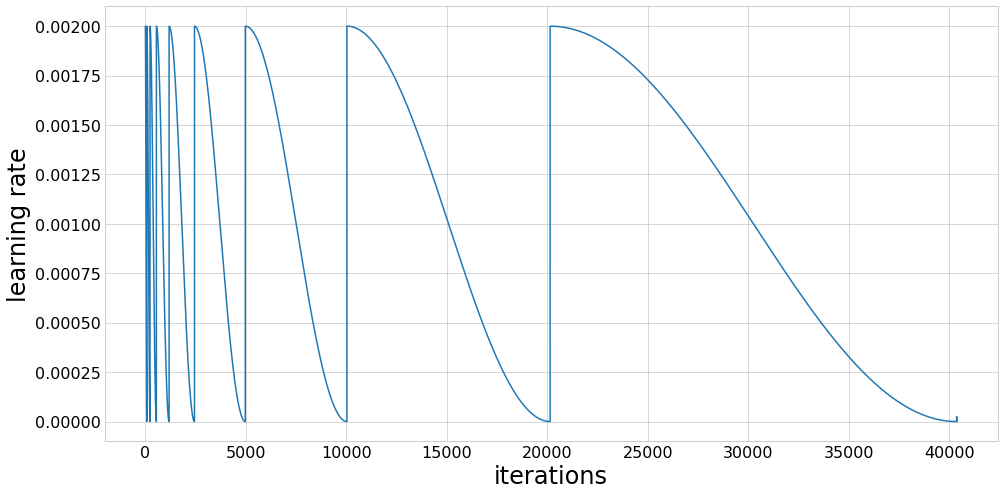

Fold took 529.211s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282589). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141643). Check your callbacks.
  % delta_t_median)


1 New best found: 4.1410887002712116e-05
2 New best found: 3.6548229394247754e-05
3 New best found: 3.6117888211447277e-05
4 New best found: 3.5912638531590346e-05
5 New best found: 3.4865475057449656e-05
6 New best found: 3.451887843984878e-05
7 New best found: 3.426158650981961e-05
10 New best found: 3.405846306268359e-05
11 New best found: 3.38931460340973e-05
12 New best found: 3.363702670030762e-05
13 New best found: 3.3575781686522534e-05
14 New best found: 3.3241890108911324e-05
15 New best found: 3.323694678983884e-05
25 New best found: 3.319673011574196e-05
26 New best found: 3.316567126312293e-05
27 New best found: 3.3013402436336036e-05
28 New best found: 3.298176529206103e-05
30 New best found: 3.295563260180643e-05
31 New best found: 3.294519172341097e-05
47 New best found: 3.2898735693015625e-05
48 New best found: 3.273444298974937e-05
50 New best found: 3.260423956817249e-05
55 New best found: 3.253467294271104e-05
56 New best found: 3.249652225204045e-05
57 New best fou

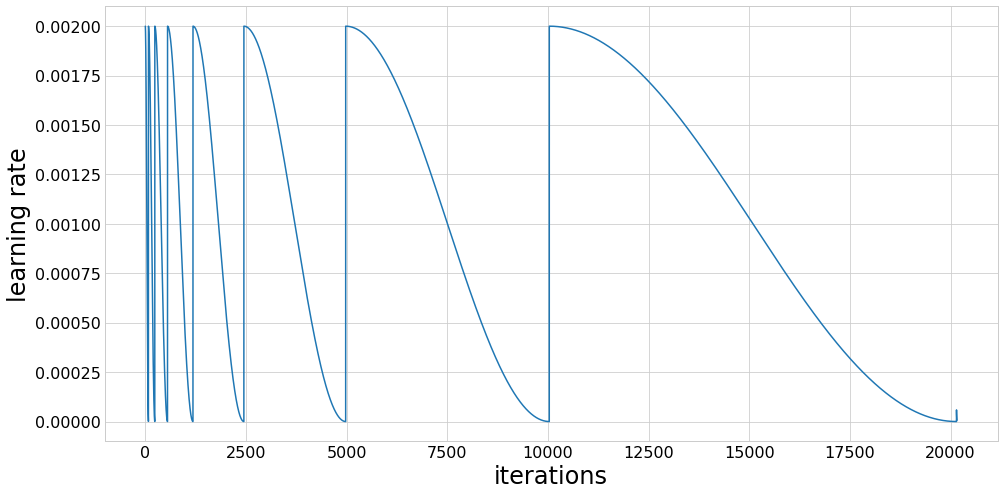

Fold took 271.797s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303503). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152148). Check your callbacks.
  % delta_t_median)


1 New best found: 3.948328558915855e-05
2 New best found: 3.698392221433621e-05
3 New best found: 3.614285645275826e-05
4 New best found: 3.5671165056408236e-05
5 New best found: 3.5261434953087836e-05
6 New best found: 3.4775827790827934e-05
7 New best found: 3.457657510445533e-05
10 New best found: 3.422108910987806e-05
11 New best found: 3.4069289204473095e-05
12 New best found: 3.389592862693733e-05
13 New best found: 3.357265238408543e-05
14 New best found: 3.355141581504618e-05
15 New best found: 3.3532849395024744e-05
22 New best found: 3.348011779411599e-05
24 New best found: 3.325355173041282e-05
25 New best found: 3.3145973678323266e-05
26 New best found: 3.303292647755195e-05
27 New best found: 3.2928521882817933e-05
28 New best found: 3.275673725381687e-05
29 New best found: 3.2708477017731995e-05
30 New best found: 3.27011372350458e-05
31 New best found: 3.270075882549307e-05
50 New best found: 3.268775817406087e-05
53 New best found: 3.2678827419782925e-05
54 New best fou

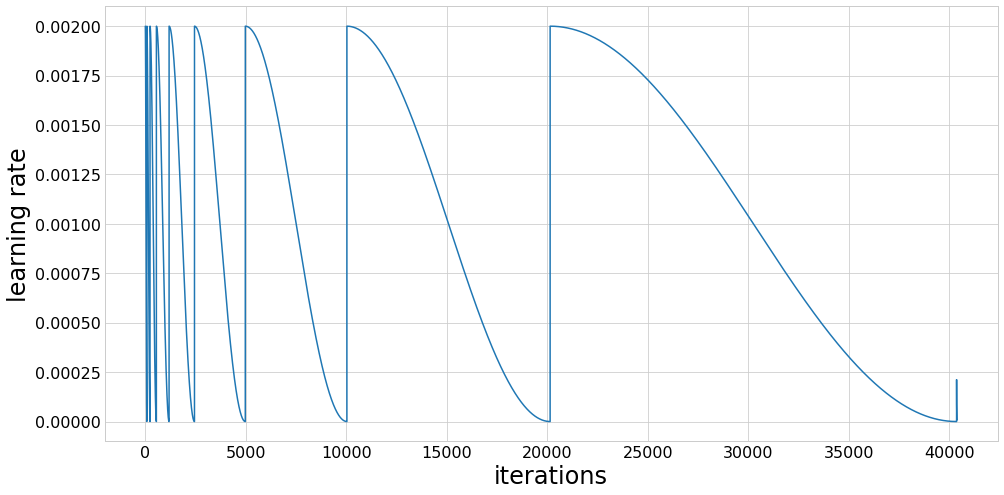

Fold took 552.141s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.322940). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161874). Check your callbacks.
  % delta_t_median)


1 New best found: 4.1000310156312444e-05
2 New best found: 3.701186385800054e-05
3 New best found: 3.6337252127270194e-05
4 New best found: 3.588363516292286e-05
5 New best found: 3.527123203974742e-05
6 New best found: 3.4541544106440886e-05
7 New best found: 3.447740207486626e-05
10 New best found: 3.4191674441518514e-05
11 New best found: 3.3965290278483824e-05
12 New best found: 3.359328685189707e-05
13 New best found: 3.3371301863937034e-05
14 New best found: 3.316540875860346e-05
15 New best found: 3.310500868819828e-05
23 New best found: 3.292466123775155e-05
24 New best found: 3.2892055651684605e-05
26 New best found: 3.286967067611429e-05
27 New best found: 3.2836141335119886e-05
28 New best found: 3.268766384437557e-05
29 New best found: 3.2649641144238597e-05
30 New best found: 3.263127672863413e-05
31 New best found: 3.262529937565083e-05
46 New best found: 3.2500138901497235e-05
51 New best found: 3.249494544699532e-05
52 New best found: 3.244878044085462e-05
54 New best f

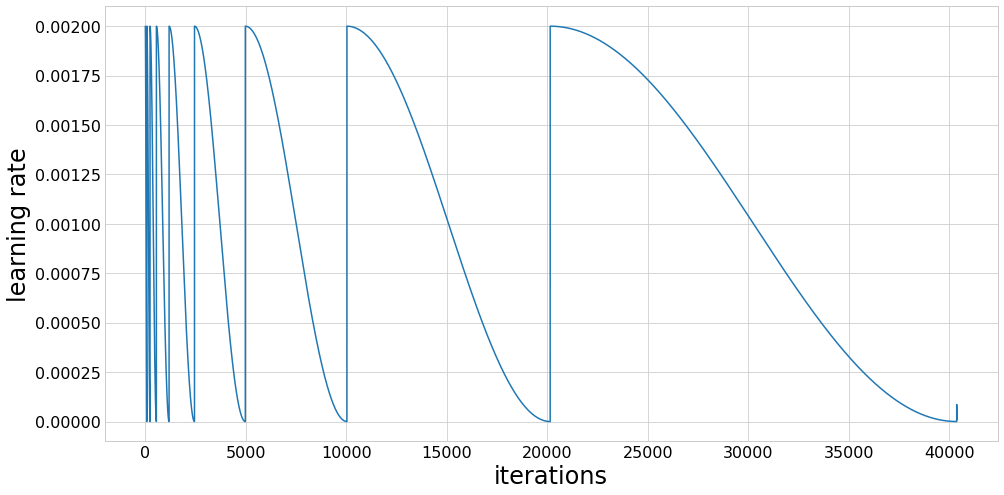

Fold took 555.632s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.343692). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172307). Check your callbacks.
  % delta_t_median)


1 New best found: 3.918637826136546e-05
2 New best found: 3.701396193209803e-05
3 New best found: 3.594785812892951e-05
4 New best found: 3.586274842818966e-05
5 New best found: 3.49382445710944e-05
6 New best found: 3.4268714670906775e-05
7 New best found: 3.4169610009121243e-05
11 New best found: 3.374176222132519e-05
12 New best found: 3.354135944100562e-05
13 New best found: 3.3322193819913085e-05
14 New best found: 3.3240973149077035e-05
18 New best found: 3.3157158106041606e-05
23 New best found: 3.296306753763929e-05
27 New best found: 3.282231854318525e-05
28 New best found: 3.2775295866304076e-05
29 New best found: 3.274434603808914e-05
30 New best found: 3.2740024444501614e-05
31 New best found: 3.2732738777121995e-05
49 New best found: 3.2665531682869186e-05
54 New best found: 3.262552573141875e-05
56 New best found: 3.255569411921897e-05
57 New best found: 3.2542402698891236e-05
58 New best found: 3.2484441551059716e-05
59 New best found: 3.247916045147577e-05
60 New best f

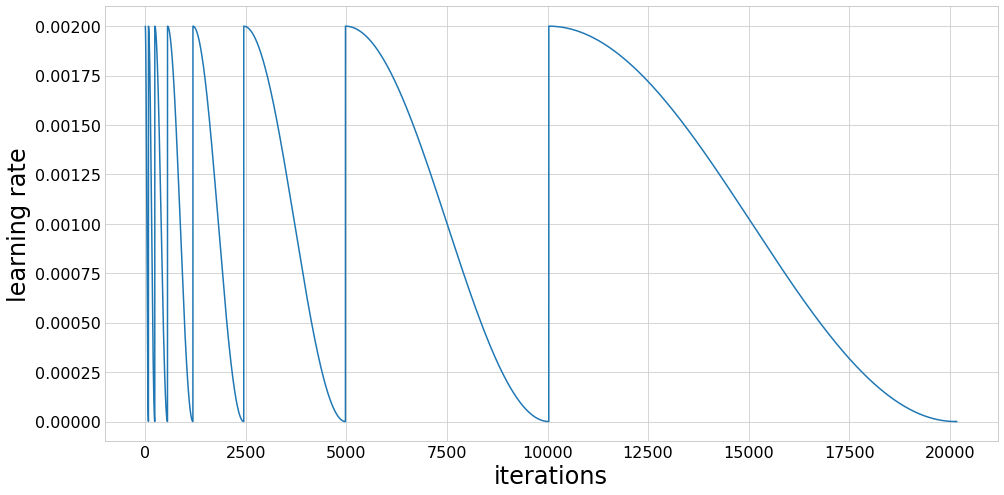

Fold took 317.016s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.374583). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187730). Check your callbacks.
  % delta_t_median)


1 New best found: 4.101632676029112e-05
2 New best found: 3.730253963149153e-05
3 New best found: 3.6415141860197766e-05
4 New best found: 3.585022024635691e-05
5 New best found: 3.499701984692365e-05
6 New best found: 3.4680652196402665e-05
7 New best found: 3.453643354587257e-05
10 New best found: 3.424368266860256e-05
11 New best found: 3.418665170029271e-05
12 New best found: 3.411199625552399e-05
13 New best found: 3.359362777991919e-05
14 New best found: 3.347007612901507e-05
15 New best found: 3.345283823437058e-05
23 New best found: 3.3290328705334105e-05
27 New best found: 3.288387298380257e-05
28 New best found: 3.2823038613423705e-05
29 New best found: 3.2784413095214404e-05
30 New best found: 3.2779287216544614e-05
31 New best found: 3.276719795831014e-05
47 New best found: 3.2673670374788345e-05
49 New best found: 3.2500015097321014e-05
51 New best found: 3.2455273403320464e-05
54 New best found: 3.24090477428399e-05
55 New best found: 3.2333944071433506e-05
57 New best fo

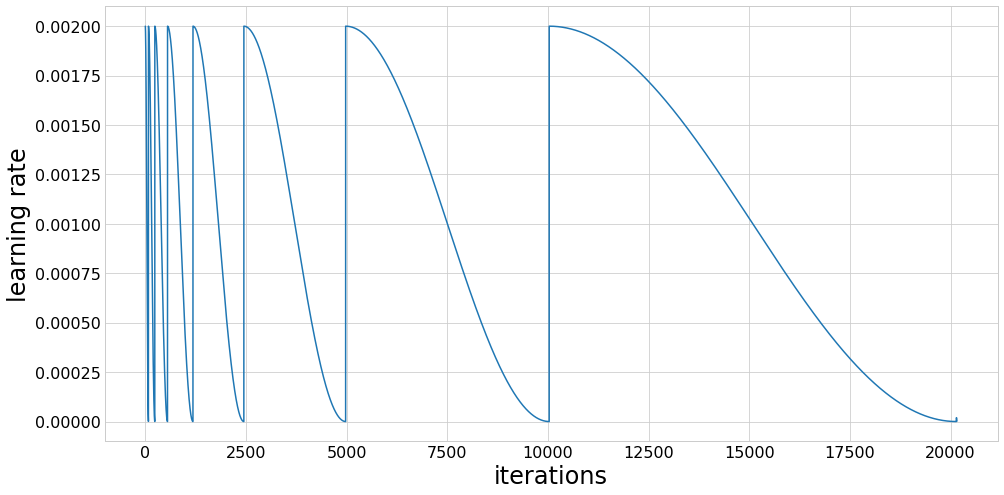

Fold took 302.486s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.405251). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203053). Check your callbacks.
  % delta_t_median)


1 New best found: 3.97940114751691e-05
2 New best found: 3.696713433309924e-05
3 New best found: 3.633148788649123e-05
4 New best found: 3.6003322260512506e-05
5 New best found: 3.4952648998296355e-05
6 New best found: 3.460222775756847e-05
7 New best found: 3.440195183648029e-05
10 New best found: 3.427528000611346e-05
11 New best found: 3.39133612535079e-05
12 New best found: 3.387460570957046e-05
13 New best found: 3.3506822638446465e-05
15 New best found: 3.3412808044522533e-05
21 New best found: 3.320190755621297e-05
22 New best found: 3.2935933842964005e-05
25 New best found: 3.280576493561966e-05
27 New best found: 3.2710460369708016e-05
28 New best found: 3.2571668206946925e-05
29 New best found: 3.2535302416363266e-05
30 New best found: 3.2531271367042794e-05
31 New best found: 3.2528076646849516e-05
47 New best found: 3.2479368703207e-05
48 New best found: 3.231730459665414e-05
55 New best found: 3.229452964587836e-05
56 New best found: 3.226249056897359e-05
57 New best found

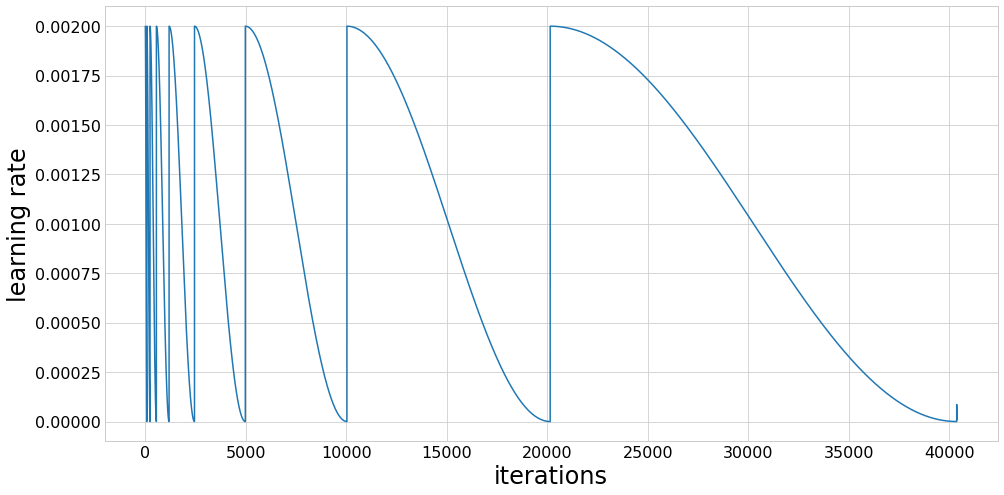

Fold took 591.308s


______________________________________
Training finished
Cross-validation took 4616.789s 


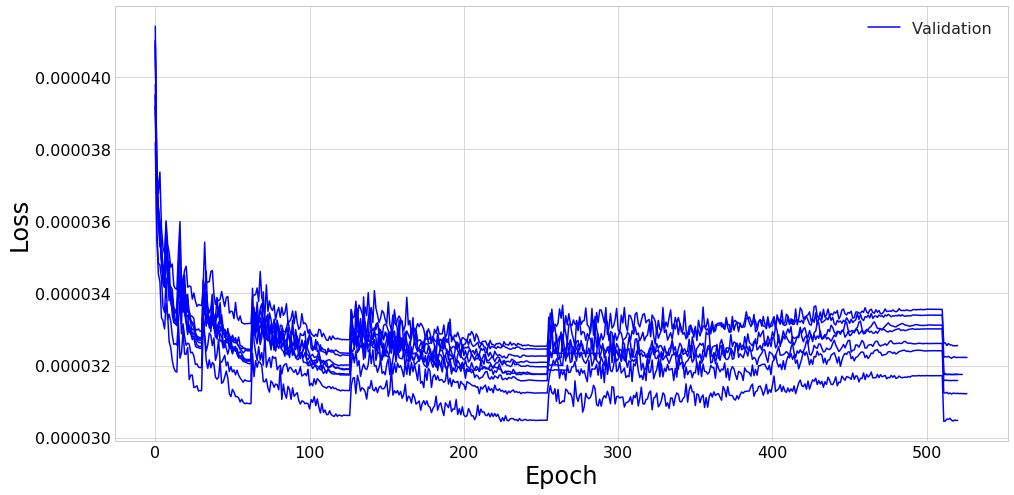

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0634 +- 0.0008
Mean AUC = 0.0986 +- 0.0009
Mean AMS = 3.96 +- 0.06
Mean cut = 0.973 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 2 with loss = 3.0448172561126535e-05
Model 1 is 1 with loss = 3.1211423233104857e-05
Model 2 is 9 with loss = 3.157243953755824e-05
Model 3 is 6 with loss = 3.174414498028089e-05
Model 4 is 3 with loss = 3.1749997352317416e-05
Model 5 is 8 with loss = 3.18663369413116e-05
Model 6 is 4 with loss = 3.1997587769001255e-05
Model 7 is 5 with loss = 3.220170591412565e-05
Model 8 is 7 with loss = 3.233879344916204e-05
Model 9 is 0 with loss = 3.252605348042119e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0017987032309174538s per sample

Predicting fold 2 out of 10
Prediction took 0.0004016400717198849s per sample

Predicting fold 3 out of 10
Prediction took 0.00039945946373045444s per sample

Predicting fold 4 out of 10
Prediction took 0.0003967776522040367s per sample

Predicting fold 5 out of 10
Prediction took 0.0004006956946104765s per sample

Predicting fold 6 out of 10
Prediction took 0.00039608219638466837s per sample

Predicting fold 7 out of 10
Prediction took 0.00039804470613598824s per sample

Predicting fold 8 out of 10
Prediction took 0.00039981724284589293s per sample

Predicting fold 9 out of 10
Prediction took 0.0003974000293761492s per sample

Predicting fold 10 out of 10
Prediction took 0.0003944899585098028s per sample



In [14]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.903676043002541, weighted 0.9362836487303148


In [15]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.930654514667693, 0.9622143)

In [16]:
%%time
cut = bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)[1]

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9618801705073565, corresponds to calc_ams of 3.899314120170004
CPU times: user 2.62 s, sys: 10.5 s, total: 13.1 s
Wall time: 4min


## Response on validation data with TTA

In [17]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                           input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.013510768418759108s per sample

Predicting fold 2 out of 10
Prediction took 0.013565216071531177s per sample

Predicting fold 3 out of 10
Prediction took 0.0135078901655972s per sample

Predicting fold 4 out of 10
Prediction took 0.013507727768272162s per sample

Predicting fold 5 out of 10
Prediction took 0.013532642921805381s per sample

Predicting fold 6 out of 10
Prediction took 0.013569406497851015s per sample

Predicting fold 7 out of 10
Prediction took 0.013627766218408941s per sample

Predicting fold 8 out of 10
Prediction took 0.013639501389488579s per sample

Predicting fold 9 out of 10
Prediction took 0.01350224821008742s per sample

Predicting fold 10 out of 10
Prediction took 0.013529236289858818s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9037552386344899, weighted 0.9362993940715316


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9523577664037943, 0.9621349)

In [21]:
%%time
tta_cut = bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)[1]

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9628591001965106, corresponds to calc_ams of 3.9150837367842337
CPU times: user 2.61 s, sys: 10.5 s, total: 13.1 s
Wall time: 3min 57s


# Test scoring - Without TTA

In [30]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [31]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0004061355181715705s per sample

Predicting fold 2 out of 10
Prediction took 0.00040329241403801874s per sample

Predicting fold 3 out of 10
Prediction took 0.00040173336650160227s per sample

Predicting fold 4 out of 10
Prediction took 0.00040425488484854046s per sample

Predicting fold 5 out of 10
Prediction took 0.0004039628790183501s per sample

Predicting fold 6 out of 10
Prediction took 0.0004088474668562412s per sample

Predicting fold 7 out of 10
Prediction took 0.00040741136195984756s per sample

Predicting fold 8 out of 10
Prediction took 0.0004055116833610968s per sample

Predicting fold 9 out of 10
Prediction took 0.00040344079475511206s per sample

Predicting fold 10 out of 10
Prediction took 0.0004054898182099516s per sample

CPU times: user 4min 2s, sys: 6.02 s, total: 4min 8s
Wall time: 3min 42s


In [32]:
score_test_data(test_fy.source, 0.9618801705073565)

Public:Private AMS: 3.695002481930898 : 3.795065203373364


(3.695002481930898, 3.795065203373364)

# Test scoring - With TTA

In [25]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                            input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


In [26]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.013131759953363376s per sample

Predicting fold 2 out of 10
Prediction took 0.0131402145489373s per sample

Predicting fold 3 out of 10
Prediction took 0.013125855661759323s per sample

Predicting fold 4 out of 10
Prediction took 0.013111034396155314s per sample

Predicting fold 5 out of 10
Prediction took 0.013123712216453119s per sample

Predicting fold 6 out of 10
Prediction took 0.013153848100284284s per sample

Predicting fold 7 out of 10
Prediction took 0.013144562485915693s per sample

Predicting fold 8 out of 10
Prediction took 0.013125659550828013s per sample

Predicting fold 9 out of 10
Prediction took 0.013136780379373918s per sample

Predicting fold 10 out of 10
Prediction took 0.013147746986929667s per sample

CPU times: user 2h 11min 4s, sys: 3min 16s, total: 2h 14min 20s
Wall time: 2h 23s


In [28]:
score_test_data(test_fy.source, 0.9628591001965106)

Public:Private AMS: 3.6282404969114195 : 3.7946512624631206


(3.6282404969114195, 3.7946512624631206)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)